# STAT 201 Project Final Report Group 20



Group members:
<br>Alan Zhang 
<br>Sneh Agarwal
<br>Taniya Cai
<br>Waxin Luo

### Introduction

Recently, bike-sharing systems have seen increasing popularity as a means of efficient transportation in urban areas. These systems are not only a feasible solution to the world’s major environmental problems, but they also play an important role in traffic and health issues. Its users are able to rent a bicycle from a convenient depot location, and return it at another one close to the user's destination. In the U.S. alone, over 60 cities have integrated bike-sharing systems, and in densely populated cities like New York, the count of cyclists can reach 10,000 per day (Walker, 2019). The ubiquity of such programs has therefore generated investigation and analysis of quantifiable data for further effectiveness. Capital Bikeshare is one such bike-sharing system, that serves the Washington D.C. metropolitan area, and publishes yearly anonymized statistics, including the daily usage times (Capital Bikeshare). 

Better estimations of traffic flow under various conditions will enable bike-sharing companies to make more appropriate decisions on dispatching bikes thus maximizing bike-sharing availability and efficiency. Previous studies suggest that weather conditions have significant impacts on bike-share frequencies and fluctuation, and among various quantitative factors that define weather, the temperature is undoubtedly the most commonly used and analyzed (Gebhart & Noland, 2014).

Washington D.C. has a dynamic temperature range, where the hot season can reach over 30 degrees celsius and the cold season can drop to below 0 degrees celsius (Weather Spark). Both the hot and cold season can last over 3 months, which provide extensive room for the application of different data analysis methods that require reproducible information.
​
The particular parameter of interest is the normalized frequency of users during different temperatures and days for bike-sharing systems. This would gauge demand, and so would be useful for possible seasonal or monthly availability decisions. The scale parameter of interest is standard deviation as it is representative of the degree of fluctuation in bike availability of the system (Institute for Operations Research and the Management Sciences, 2020). 

Since it is more likely to have casual users in warmer weather, it is hypothesized that both the fluctuation and the average count of rental bikes will decrease in the cold season, hence we are expecting to see that the average and standard deviation of the number of bike shares in the mild season (spring) to be larger than a cold season (winter).

### Methods and Results

In [2]:
library(repr)
library(tidyverse)
library(dplyr)
library(grid)
library(infer)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



The first step is to download the dataset zip file from the website, unzip the files, and load the dataset into R. We name the dataset as bike.

In [3]:
dir.create("data")
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
download.file(url,"data/Bike-Sharing-Dataset.zip")
unzip("data/Bike-Sharing-Dataset.zip", files="day.csv", exdir="data/")
bike <- read_csv("data/day.csv") 
head(bike)
print("Table 1")

Warning message in dir.create("data"):
“'data' already exists”
Rows: 731 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (15): instant, season, yr, mnth, holiday, weekday, workingday, weathers...
date  (1): dteday

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.1604460,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.2485390,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.2483090,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.1602960,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.1869000,82,1518,1600
6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.0895652,88,1518,1606


[1] "Table 1"


Table 1 features part of the original dataset. Since season is an appropriate generalization of factors such as temperature, it is a feasible choice to use to determine our preliminary results. 

In [4]:
bike <- bike %>%
 select(season, cnt)
print("Table 2 Cleaned bike dataset")
head(bike)

[1] "Table 2 Cleaned bike dataset"


season,cnt
<dbl>,<dbl>
1,985
1,801
1,1349
1,1562
1,1600
1,1606


The parameters of interest, 'season' and 'cnt' are selected. 'cnt' refers to the count of total of rental bikes and 'season' refers to the seasons in a year categorized as 1: Winter, 2: spring, 3: summer and 4: fall. Season is represented incorrectly as a numerical variable in table 2, so we changed it to a categorical variable.

In [5]:
bike$season <- as.factor(bike$season)

Although we have specified to use mean and standard deviation as parameters of interest, for preliminary analysis we think that it is more visually effective to use side-by-side boxplots to compare distributions among categorical variables.

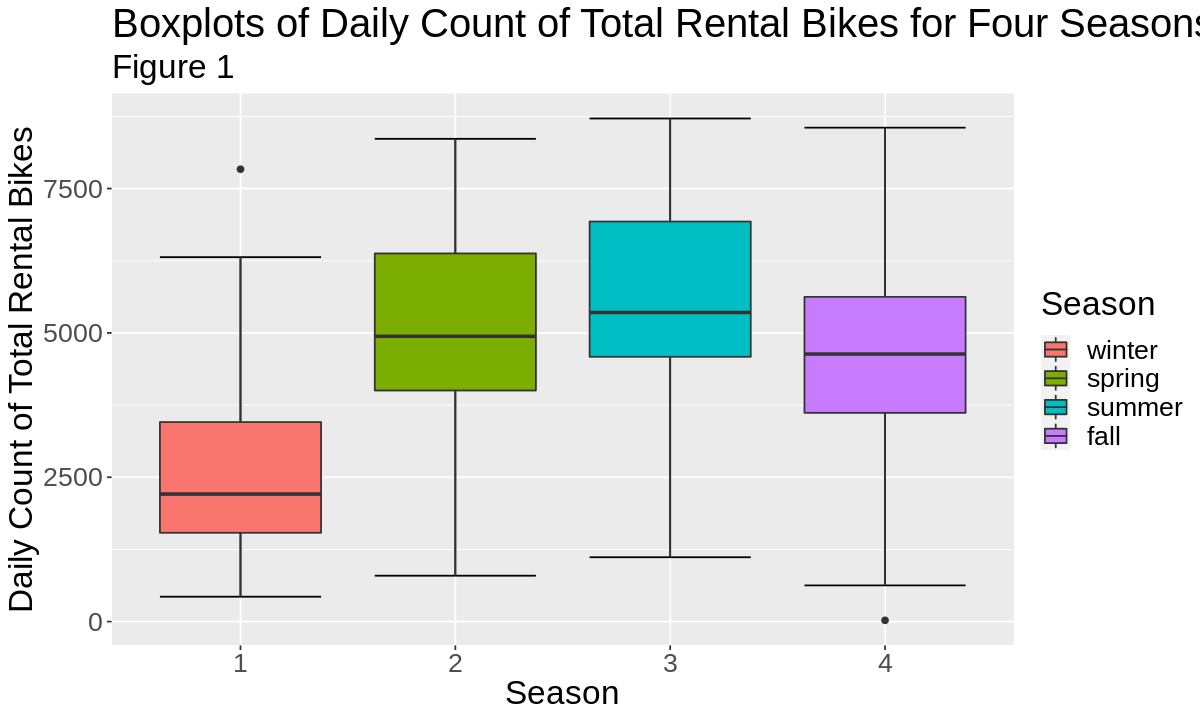

In [6]:
boxplots <- bike %>%  
          ggplot(aes(x = season, y = cnt, fill = season)) + 
          stat_boxplot(geom ='errorbar') + 
          geom_boxplot() + 
          labs(x = "Season", y = "Daily Count of Total Rental Bikes", 
               title = "Boxplots of Daily Count of Total Rental Bikes for Four Seasons",
               subtitle = "Figure 1") +
          theme(text = element_text(size=20)) +
          scale_fill_discrete(name = "Season", labels = c("winter", "spring", "summer", "fall"))
options(repr.plot.height = 6, repr.plot.width = 10)
boxplots

In [7]:
bike_summary <- bike %>% 
     group_by(season) %>% 
     summarize(n = n(), Average_Count = mean(cnt), Median_Count = median(cnt), Standard_Dev = sd(cnt),
               IQR = quantile(cnt, 0.75) - quantile(cnt, 0.25), min = min(cnt), max = max(cnt))
print("Table 3 Preliminary results")
bike_summary

[1] "Table 3 Preliminary results"


season,n,Average_Count,Median_Count,Standard_Dev,IQR,min,max
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,181,2604.133,2209.0,1399.942,1918.00,431,7836
2,184,4992.332,4941.5,1695.977,2374.00,795,8362
3,188,5644.303,5353.5,1459.800,2342.75,1115,8714
4,178,4728.163,4634.5,1699.615,2009.00,22,8555


Table 3 provides an exhaustive list of summary statistics for the daily count of the four seasons. We included our parameter of interest (standard deviation) as well as other statistics that may be helpful in better understanding the preliminary results. It can be observed that preliminary analysis supports our hypothesis of having larger standard deviation in milder seasons (spring-2 and fall-4).

We decided to transform the dataset to have two distinct seasons, where spring counts will be represented as "mild" and winter counts will be represented as "cold". Table 4 contains this change.

In [8]:
bike$season <- as.character(bike$season)      # convert factor to character
bike$season[bike$season == "1"] <- "cold"
bike$season[bike$season == "2"] <- "mild" 
bike$season <- as.factor(bike$season)         # convert back to factor
bike_reduced <- bike %>%
    filter(season == "cold" | season == "mild")
print("Table 4 Reduced bike dataset")
head(bike_reduced)

[1] "Table 4 Reduced bike dataset"


season,cnt
<fct>,<dbl>
cold,985
cold,801
cold,1349
cold,1562
cold,1600
cold,1606


Now we will take a look of the reduced data

In [9]:
bike_summary <- bike_reduced %>% 
    group_by(season) %>% 
    summarize(n = n(), count_median = median(cnt), count_average = mean(cnt), sd = sd(cnt),
             IQR = quantile(cnt, 0.75) - quantile(cnt, 0.25), min = min(cnt), max = max(cnt))
print("Table 5 Summary statistics of reduced data")
bike_summary

[1] "Table 5 Summary statistics of reduced data"


season,n,count_median,count_average,sd,IQR,min,max
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cold,181,2209.0,2604.133,1399.942,1918,431,7836
mild,184,4941.5,4992.332,1695.977,2374,795,8362


The data is cleaned and wrangled with no missing values and is of a sufficient and comparable sample size, which suggests that it is representative of our population and our explanatory variable season.

#### Bootstrapping VS. Asymptotic Analysis

The CLT states that for sufficiently large samples with n >= 30, the sampling distribution of sample means will tend towards a normal distribution regardless of the original distribution of the population. In the dataset, both samples are of sufficient size. Hence, we can use CLT to approximate the sampling distribution of sample means through taking multiple samples of both groups and calculated their means.

To visualized the comparison, we use histograms to show the distribution of our data:

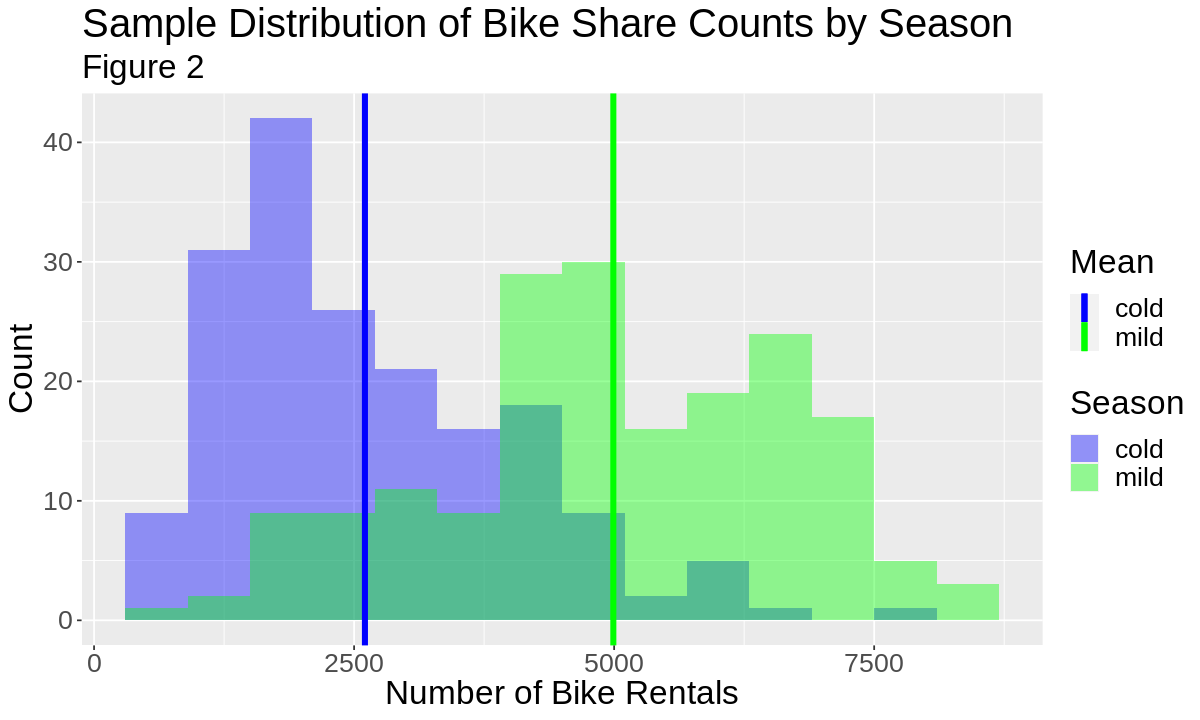

In [10]:
options(repr.plot.height = 6, repr.plot.width = 10)

overlayed_distribution <- bike_reduced %>% 
    ggplot(aes(x = cnt, fill = season)) +
    scale_fill_manual(name = "Season", values = c("cold" = "blue", "mild" = "green"))+
    geom_histogram(position = "identity", binwidth = 600, alpha = 0.4) +
    labs(x = "Number of Bike Rentals", y = "Count", 
         title = "Sample Distribution of Bike Share Counts by Season",
         subtitle = "Figure 2") +
    theme(text = element_text(size = 20)) + 
    geom_vline(aes(xintercept = bike_summary$count_average[1], color = "cold"), size = 1.7) +
    geom_vline(aes(xintercept = bike_summary$count_average[2], color = "mild"), size = 1.7) +
    scale_color_manual(name = "Mean", values = c("cold" = "blue", "mild" = "green"))

overlayed_distribution

##### Hypothesis for location parameter (mean):

$H_{0}$ : The mean count of bike rentals of cold season is the same as the mean count of bike rentals of mild season.

$H_{A}$ : The mean count of bike rentals of cold season less than the mean count of bike rentals of mild season.

##### Hypothesis for scale parameter (standard deviation):

$H_{0}$ : The standard deviation of bike rentals of cold season is the same as the standard deviation count of bike rentals of mild season.

$H_{A}$ : The standard deviation of bike rentals of cold season is less than the standard deviation count of bike rentals of mild season.

#### Applying the Large Sample Theory for Location Parameter (Mean)

Since we have justified that CLT is applicable to our dataset, it is now appropriate to use the two-sample t-test to compare the means of the two seasons. Here, since we expect the standard deviation (hence also variance) of the two groups to be different, we will be using the Welch Two Sample t-test, where it is assumed that the variances are unequal and the means are equal.

In [11]:
cold_counts <- bike_reduced %>%
  filter(season == "cold") %>%
  pull(cnt)
mild_counts <- bike_reduced %>%
  filter(season == "mild") %>%
  pull(cnt)
diff_in_mean_stat <- t.test(cold_counts, mild_counts, alternative = "less", var.equal = FALSE)      # conducting unpaired two sample t-test with unequal variances
p_value_t_mean <- tibble(p_value. = diff_in_mean_stat$p.value)
print("Table 6 Summary statistics for t-test")
diff_in_mean_stat
print("Table 7 p-value for mean through t-test")
p_value_t_mean

[1] "Table 6 Summary statistics for t-test"



	Welch Two Sample t-test

data:  cold_counts and mild_counts
t = -14.682, df = 352.41, p-value < 2.2e-16
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
      -Inf -2119.933
sample estimates:
mean of x mean of y 
 2604.133  4992.332 


[1] "Table 7 p-value for mean through t-test"


p_value.
<dbl>
1.031277e-38


A p-value is the probability of obtaining a test statistic just as extreme, more extreme, or more than the observed statistic assuming the null hypothesis is true. Table 7 calculates the p-value for the mean through the t-test to be 1.031277e - 38. The p-value of 1.031277e - 38 is extremely close to 0, and therefore suggests that we should not accept the null hypothesis. This leaves us with the possibility of committing a type 1 error. The type-1 error is committed when we reject the null hypothesis when it may actually be true.

#### Bootstrapping Analysis for Location Parameter (Mean)

We set a seed to make sure our result is reproducible. We take 1000 Bootstrap samples to create an approximation of the sampling distribution, and produce a table of summary statistics and a visualization. We use a confidence interval of 95% as we think it is reliable and is expected to include the true population parameter 95% of the time.

[1] "Table 8 Summary statistics of bootstrapping for mean"


median,mean,standard_deviation
<dbl>,<dbl>,<dbl>
2390.694,2394.825,164.1392


[1] "Table 9 95% confidence interval of bootstrapping result for mean"


lower_ci,upper_ci
<dbl>,<dbl>
2072.236,2708.195


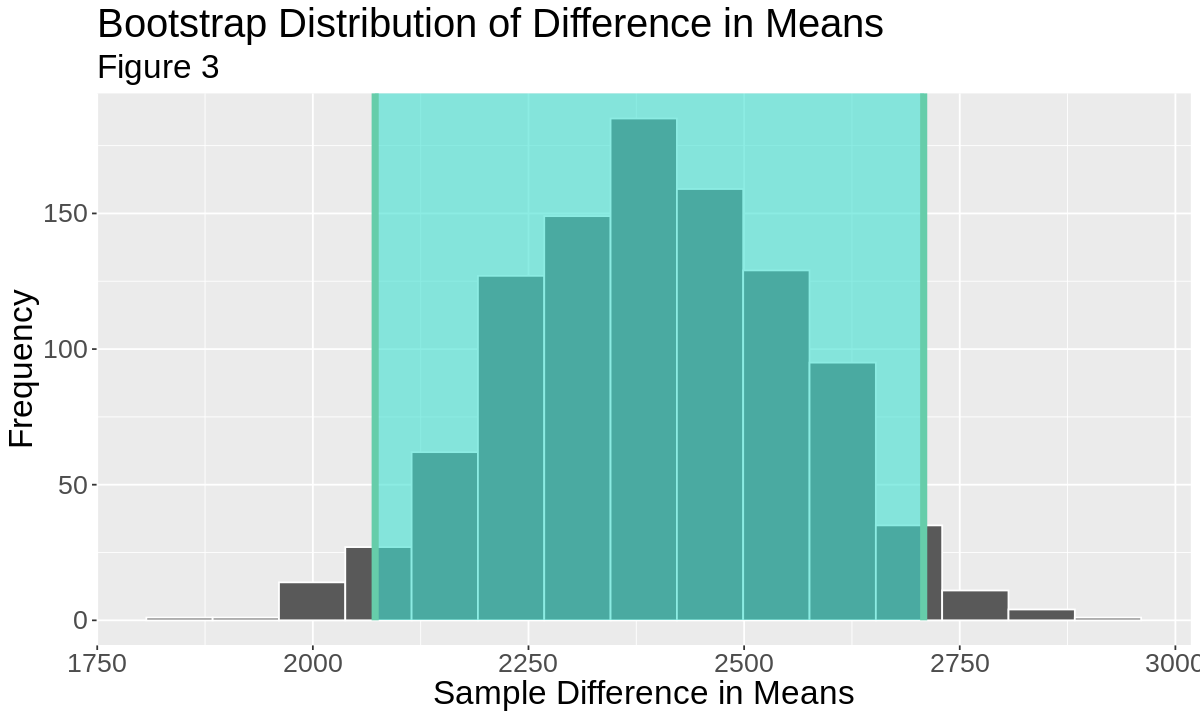

In [14]:
set.seed(1234)

bike_reduced$season <- droplevels(bike_reduced$season)

bootstrap_dist = bike_reduced %>% 
    specify(formula = cnt ~ season) %>% 
    generate(reps = 1000, type = "bootstrap") %>% 
    calculate(stat = "diff in means", order = c("mild", "cold"))

bootstrap_ci = bootstrap_dist %>% 
    get_ci(0.95, type = "percentile")

bootstrap_summary <- bootstrap_dist %>% 
    summarise(median = median(stat), mean = mean(stat), standard_deviation = sd(stat))

print("Table 8 Summary statistics of bootstrapping for mean")
bootstrap_summary
print("Table 9 95% confidence interval of bootstrapping result for mean")
bootstrap_ci

bootstrap_dist_graph <- visualize(bootstrap_dist) + 
    shade_ci(endpoints = bootstrap_ci) + 
    labs(x = "Sample Difference in Means", y = "Frequency", 
         title = "Bootstrap Distribution of Difference in Means",subtitle = "Figure 3") + 
    theme(text = element_text(size = 20))

bootstrap_dist_graph

From the intervals calculated in Table 9, we are 95% confident that the true difference in means lies between 2072.236 and 2708.195. We can now use the bootstrap distribution to test against the null hypothesis and produce the p-value. Our null hypothesis is that the mean difference is 0.

In [15]:
set.seed(1234)

bike_reduced$season <- droplevels(bike_reduced$season)

diff_in_mean_null_dist <- bike_reduced %>%
    specify(formula = cnt ~ season) %>% 
    hypothesise(mu  = 0, null = "independence") %>% 
    generate(reps = 1000, type = "permute") %>% 
    calculate(stat="diff in means", order = c("mild", "cold"))

p_value_mean <- get_p_value(diff_in_mean_null_dist, 
                      obs_stat = bike_summary$count_average[2] - bike_summary$count_average[1], 
                      direction = "greater")

bootstrap_ci <- diff_in_mean_null_dist %>% 
    get_ci(0.95, type = "percentile")

print("Table 10 P-value for mean")
p_value_mean
print("Table 11 95% confidence interval of hypoethesis test for mean")
bootstrap_ci

Warning message:
“Parameter values are not specified when testing that two variables are independent.”
Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


[1] "Table 10 P-value for mean"


p_value
<dbl>
0


[1] "Table 11 95% confidence interval of hypoethesis test for mean"


lower_ci,upper_ci
<dbl>,<dbl>
-394.7946,391.7279


Due to the simulation-based nature of the {infer} package, the p_value suggests that the observed statistic is more extreme than every test statistic generated to form the null distribution, resulting in an approximate p-value of 0. An approximate p-value of 0 suggests that it is within our significance interval of 0.01. A small p-value suggests that we should not accept the null hypothesis as there is stronger evidence in favor of the alternative hypothesis.

#### Analysis for Scale Parameter (Standard Deviation)

Since we are interested in comparing the differences in standard deviation of the two groups, the most appropriate test would be the one-sided F-test for difference in variance.A one-sided F-test measures if the variance of the first population is either less or greater than the other one. We have set alternative= "less", as we want to determine that the standard deviation is less in the cold season than in the mild season.

In [16]:
diff_in_sd_stat <- var.test(cnt ~ season, bike_reduced, 
         alternative = "less")
print("Table 12 F-test statistics for standard deviation")
diff_in_sd_stat
p_value_sd <- tibble(p_value. = diff_in_sd_stat$p.value)
print("Table 13 p-value for standard deviation")
p_value_sd

[1] "Table 12 F-test statistics for standard deviation"



	F test to compare two variances

data:  cnt by season
F = 0.68137, num df = 180, denom df = 183, p-value = 0.005069
alternative hypothesis: true ratio of variances is less than 1
95 percent confidence interval:
 0.0000000 0.8705077
sample estimates:
ratio of variances 
         0.6813655 


[1] "Table 13 p-value for standard deviation"


p_value.
<dbl>
0.005068686


The p-value obtained through the difference in standard deviation is 0.005068686, which suggests that we should not accept the null hypothesis with a significance level of 1%, since it is extremely close to 0. It is reflected that there is strong evidence suggesting a difference in standard deviation between the cold and mild seasons.

### Discussion

Our initial hypothesis was to determine if the mean count of bike rentals per day in the mild season(spring) is larger than that in the cold season(winter). As such, the result of our t-test is interpreted as being a one-sided test. Given this, in the Welch Two Sample t-test, assuming the null hypothesis is true, we have a 1.031277e-36% chance of observing a result as extreme or more extreme as our observed difference. The p-value is very small here, which means at a significance level of 0.01, the chance of getting our observed value assuming a true null hypothesis is actually very unlikely. Therefore, we reject the null hypothesis at 0.01 significance. In other words, our findings show that the mean counts of rental bikes per day in spring and winter are significantly different.

From the bootstrap analysis, we have found that the p-value is 0, within the significance interval of 0.01 as well. Therefore, we reject the null hypothesis in favor of the alternative hypothesis, so it is concluded that the mean counts of rental bikes per day in spring and winter are indeed different. As both the bootstrap and Welch Two Sample t-test analyses show that we should reject the null hypothesis, it was concluded that rejecting the null hypothesis in favor of the alternative hypothesis to be the correct option.

Given the reports we referenced from the journal named Transportation and the previous weather data in Washington, we originally expected to find significantly different of the count of bike rentals per day between mild season and cold season. This is because, given the Köppen climate classification of Washington being humid subtropical climate (Weatherbase, 2022), it is characterized by hot and humid summers with mild winters, resulting in large differences in weather between seasons.

Once we loaded the data and began to analyze it, we started to see that the result is matched with our expectations. In the preliminary analysis, Figure 1 showed very different boxplots between the two seasons. However, plotting the data was not enough to come to the conclusion and our hypothesis tests confirmed once again that our initial assumption was correct.
 

We have the following questions and implications for future discussion:

>The data-driven company can use the result of the hypothesis test to make decisions about bike dispatching. It’s reasonable to dispatch more bikes in the hot season than in the cold season. Moreover, with the aim to increase the use of rental bikes and make more profit, bike companies can do some promotions during winter, such as putting advertisements in public areas and offering a special discount for new users.

 

>Is there a difference between spring and summer? Referring to the side-by-side boxplot, the difference is not obvious. What decision should be made by the company if there’s a difference?

 

>If we can access to the weather data for every specific day in Washington, we can introduce the temperature as a new interested variable to explore the relationship between temperature and the number of rental bikes per day. A linear regression model can be generated here to predict the future count of rental bikes.



>If we can access data for multiple cities, we can then find if climate as a whoe plays a role in bike-sharing during different seasons, by using the Köppen climate classification model climate zones.

### References

Belda, Michal et. al. (2014). Climate classification revisited: from Köppen to Trewartha. Climate Research. from <br>https://www.int-res.com/articles/cr_oa/c059p001.pdf

Capital Bikeshare. (n.d.). The History of Capital Bikeshare. Capital Bikeshare. Retrieved March 5,
2022, from
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;https://ride.capitalbikeshare.com/about 

Gebhart, K., & Noland, R. B. (2014). The impact of weather conditions on bikeshare trips in Washington, DC. Transportation, 
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;41(6), 1205–1225. https://doi.org/10.1007/s11116-014-9540-7

Institute for Operations Research and the Management Sciences. (2020, January 6). Maximizing bike-share ridership: New 
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;research says it's all about location: 10% increase in bike-availability levels increases ridership by 12%. ScienceDaily. 
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Retrieved March 4, 2022 from www.sciencedaily.com/releases/2020/01/200106141616.htm

Walker, A. (2019, December 16). How bike share became the decade's Biggest Transit Success Story. Curbed. Retrieved <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;April 4, 2022, from https://archive.curbed.com/2019/12/16/20864145/bike-share-citi-bike-jump-uber

Weather Spark. (n.d.). Climate and Average Weather Year Round in Washington, D.C. weatherspark.com. Retrieved April 4, <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2022, from https://weatherspark.com/y/20957/Average-Weather-in-Washington-D.C.;-United-States-Year-Round

Weatherbase. (n.d.). Washington, District of Columbia. weatehrbase.com. Retrieved April 9, <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2022, from https://www.weatherbase.com/weather/weather-summary.php3?s=50427&cityname=Washington,+District+of+Columbia,+United+States+of+America